# encoder-GAN learnable latent mapping

### Description of idea

There exists problem of GAN inversion, where we want to learn a map to latent codes of GAN, which ultimately enables us to edit images in latent space and produce transitions from one another.

What we want to try is to utilize latent space of pretrained encoder, which was trained in ss contrastive manner (cause we know that it's latent space is great). We want to learn mapping $m(\cdot)$ from latent space of this encoder to latent space of encoder to latent space of GAN. 

We also propose a new pipeline for this kind of training. Usually there exists a complex pipeline starting from image which is encoded into latent, then mapped, then decoded by GAN into generated image. This pipeline suggest usage of complex 'consistency' losses, which account for reconstruction of image being inverted from latent codes. Instead we suggest to start from latent codes, generate an image and then encode it. This naturally eliminates needs for any consistency loss, as we are operating purely on latents.

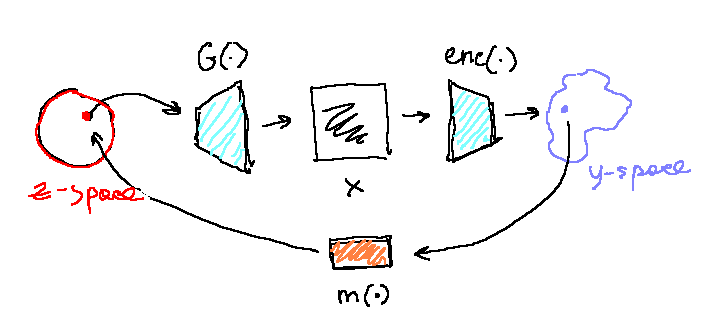

Here, only mapping $m(\cdot)$ is trainable, everything else is pretrained and fixed!

### Simplest experiment with MNIST dataset

For our simplest experiment, we need to obtain two things

- generator $G(\cdot)$ from GAN training on MNIST
- self-supervised trained encoder $enc(\cdot)$, also trained on MNIST

After that, we are ready to learn our mapping $m(\cdot)$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_gan import Generator
from train_encoder import SimCLR

import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

In [3]:
z_dim=100
y_dim=512

class M(nn.Module):
    """Learnable projection from y-space to z-space"""
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, z_dim):
        super().__init__()
        layers = [nn.Linear(y_dim, hidden_dim)]
        for _ in range(n_hidden_layers):
            layers += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim)]
        layers += [nn.GELU(), nn.Linear(hidden_dim, z_dim)]
        self.projection = nn.Sequential(*layers)

    def forward(self, y):
        return self.projection(y)

In [74]:
G = Generator().to(DEVICE)

resnet = torchvision.models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
E = nn.Sequential(*list(resnet.children())[:-1]).to(DEVICE)

G.load_state_dict(torch.load("models/mnist_gan.pth"))
E.load_state_dict(torch.load("models/encoder_mnist.pth"))
                  
for p in G.parameters():
    p.requires_grad = False

for p in E.parameters():
    p.requires_grad = False

n_hidden=3
hidden_dim=128
mapping = M(3, 128, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
loss_fn = F.mse_loss

In [8]:
holdout_mnist = MNIST(root="data", train=False, download=True, transform=T.Compose([
    T.Resize(28),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
]))

# evaluation samples are used to check that enc(img) -> y -> m(y) -> G(m(y)) is a valid inversion
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)

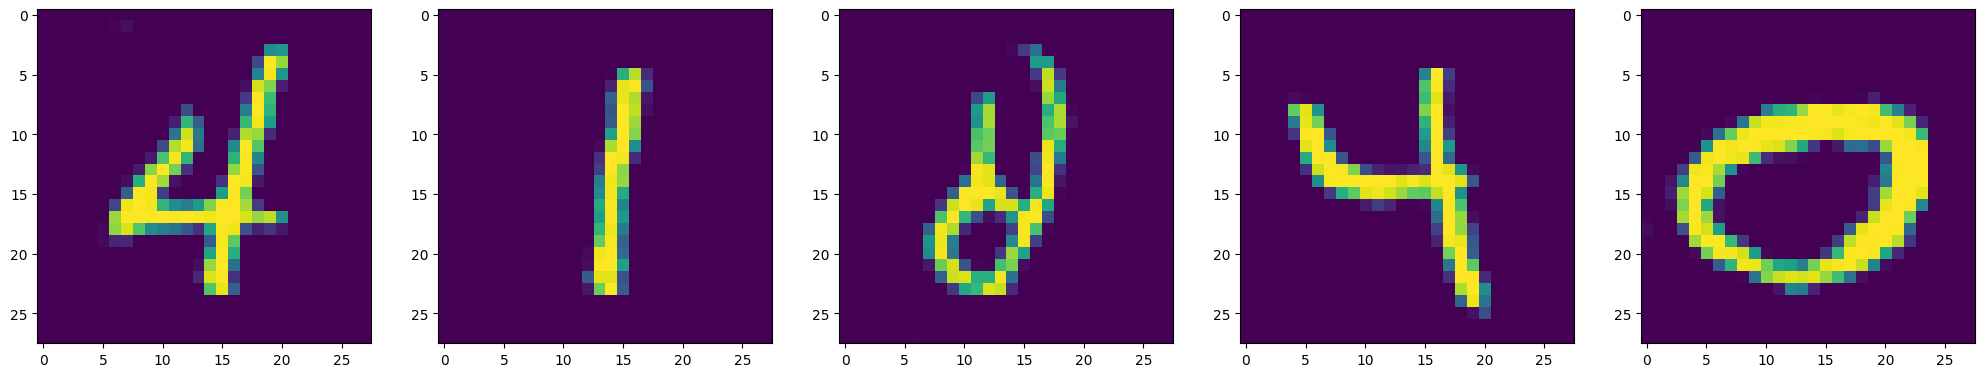

In [69]:
# gan quality sanity check
z = torch.randn((bs, z_dim), device=DEVICE)
with torch.no_grad():
    images = G(z[:,:, None, None])

images = images.detach().cpu().numpy()
_, axs = plt.subplots(1, 5, figsize=(25, 10))
for (ax, img) in zip(axs, images):
    ax.imshow(img.reshape((28, 28)))

In [76]:
num_iters=2000
eval_on=100
bs=256

G.eval()
E.eval()
mapping.train()
p_bar = tqdm(range(num_iters))
for i in p_bar:
    optimizer.zero_grad()
    z = torch.randn((bs, z_dim), device=DEVICE)
    with torch.no_grad():
        images = G(z[:,:, None, None])
        y = E(images).squeeze()
    z_hat = mapping(y)
    loss = loss_fn(z_hat, z)
    loss.backward()
    optimizer.step()
    p_bar.set_description(f"loss: {loss.item():.5f}")


torch.save(mapping.state_dict(), f"models/mapping_{n_hidden}_{hidden_dim}.pth")

loss: 0.91591: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.66it/s]


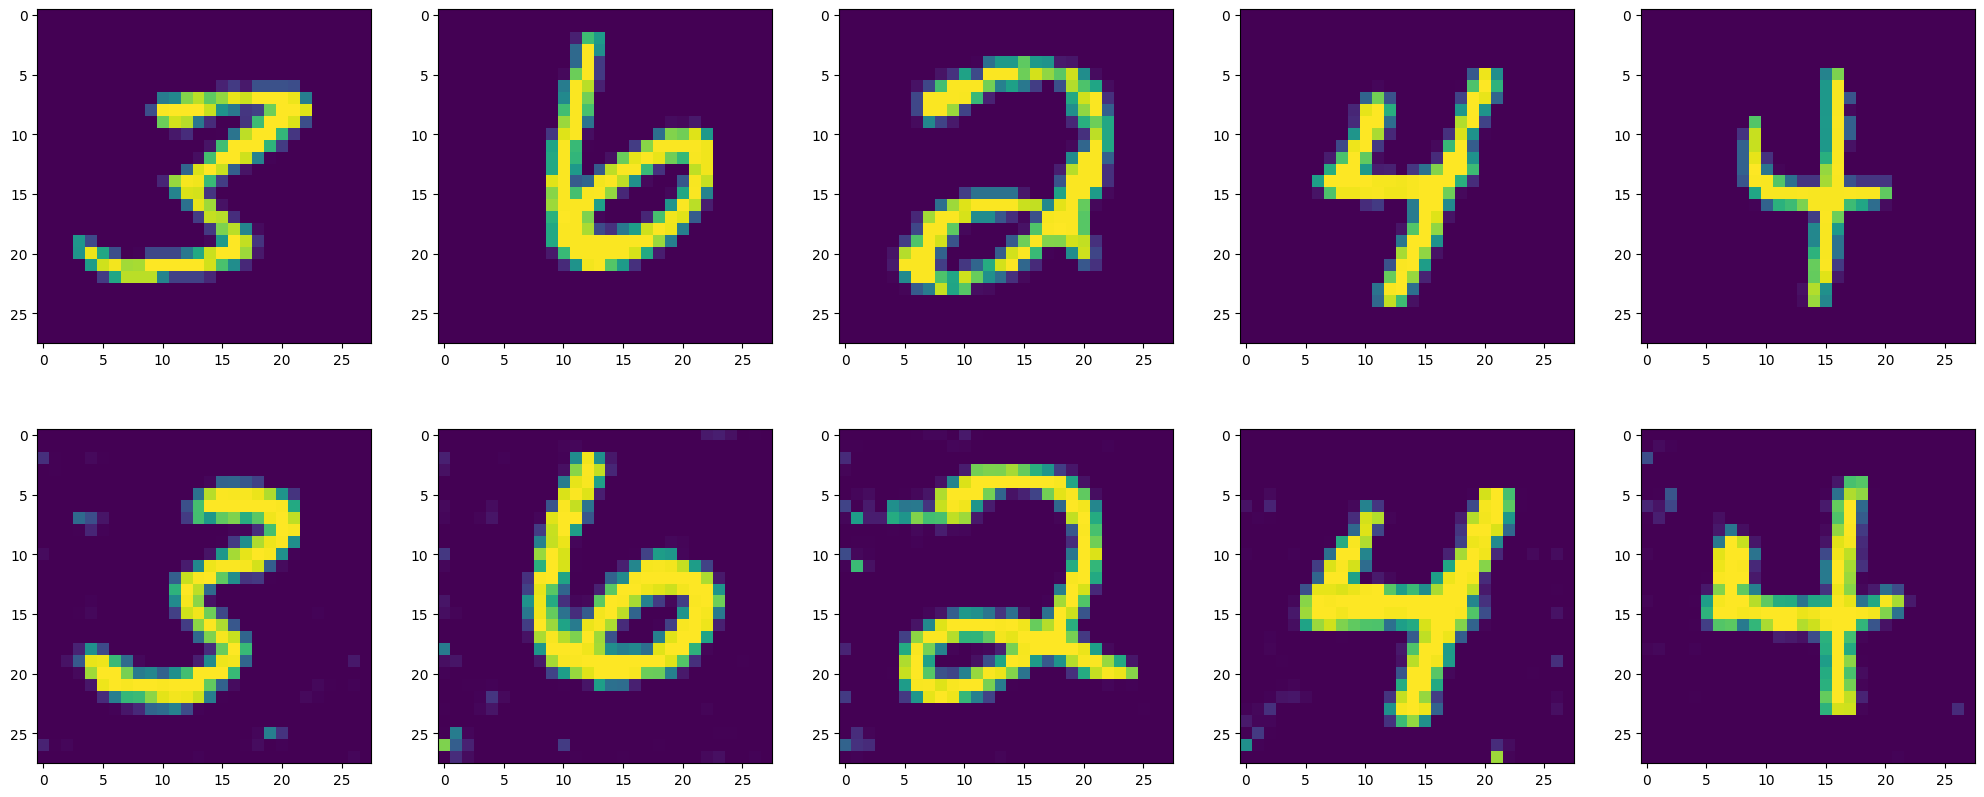

In [77]:
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    y = E(eval_samples).squeeze()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

for i in range(5):
    img_orig = eval_samples[i].cpu().numpy().reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()

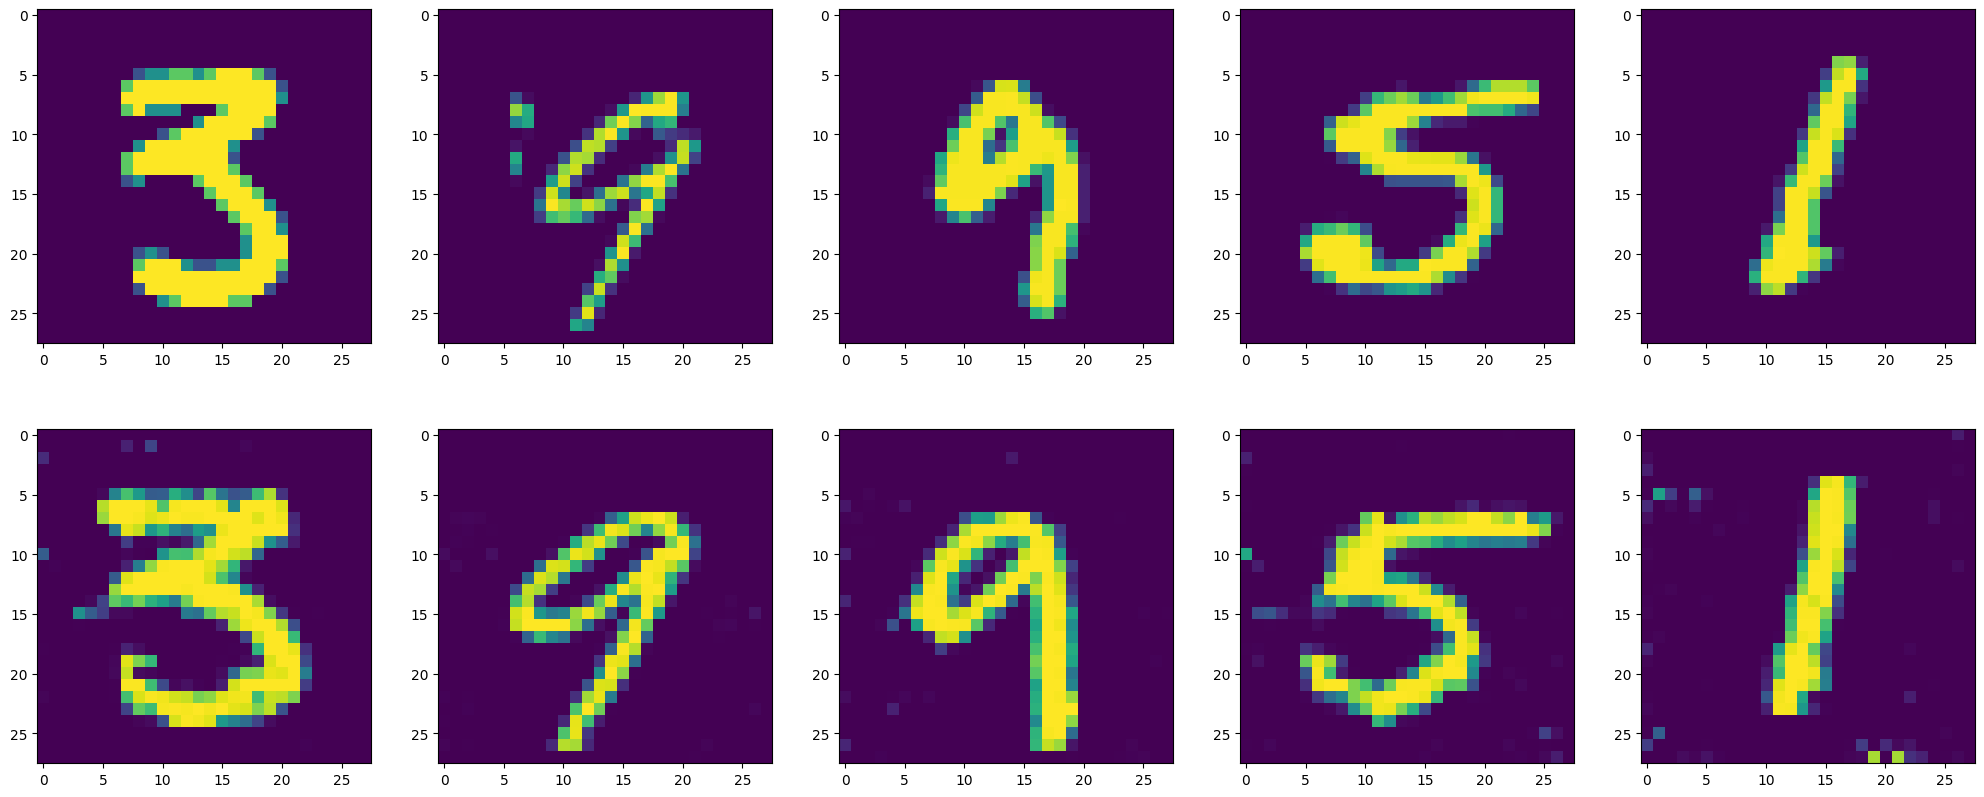

In [80]:
# check on other random samples
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    y = E(eval_samples).squeeze()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

for i in range(5):
    img_orig = eval_samples[i].cpu().numpy().reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()

### Follow-up experiment

Additionally we want to explore if our learned map $m(\cdot)$ allows for nice latent interpolations. 

That is, given a pair of images $(x_1, x_2)$, we want to traverse linear interpolation between $y_1 = enc(x_1)$ and $y_2 = enc(x_2)$ and by generating from $m(y_k)$ intermideate step $k$. 

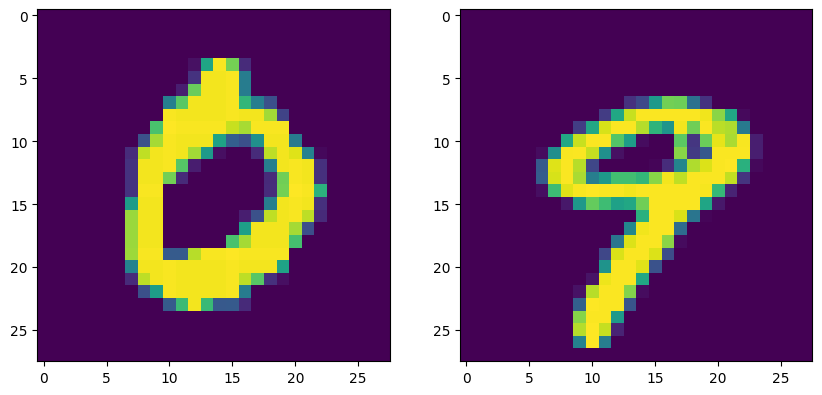

In [144]:
# 2, 6 - 1 and 4, similar, z-interpolation is better (guess their regions are connected)
# 3, 9 - 0 and 9, rather different, y-interpolation is better
i1, i2 = 3, 9
img1, img2 = holdout_mnist[i1][0], holdout_mnist[i2][0]

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1.reshape(28, 28))
axs[1].imshow(img2.reshape(28, 28))
plt.show()

In [145]:
y1, y2 = E(img1[None, :].cuda()), E(img2[None, :].cuda())

k=9
interpolations = [y1]
for a in range(1, k):
    interpolations.append(y1 + a*(y2 - y1)/k)
interpolations.append(y2)

In [146]:
mapping.eval()
images = []
for y_k in interpolations:
    with torch.no_grad():
        z_k = mapping(y_k.squeeze()[None, :])
        img_k = G(z_k[:, :, None, None])
    images.append(img_k.detach().cpu().numpy().squeeze())
    

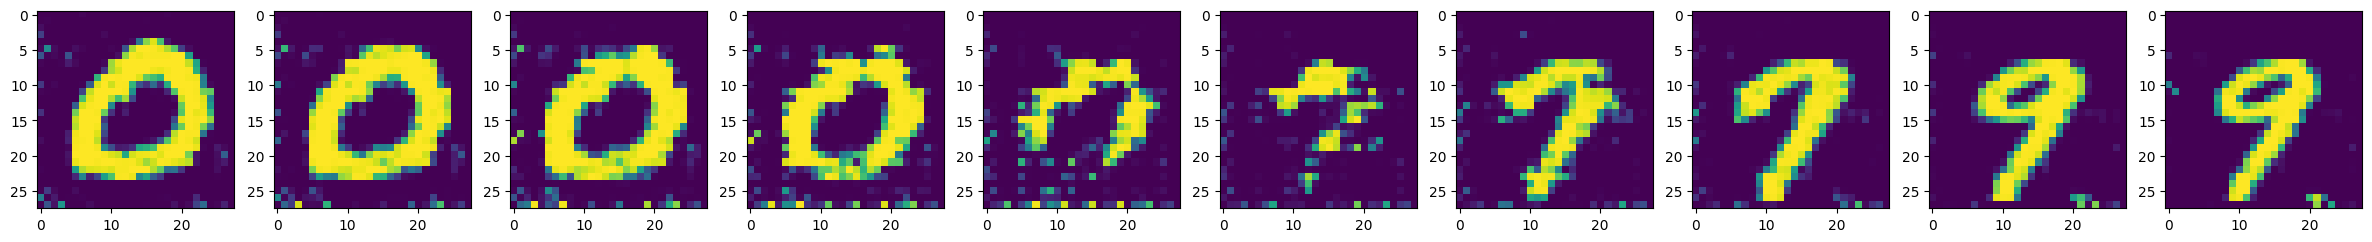

In [147]:
_, axs = plt.subplots(1, 10, figsize=(30, 3))
for (ax, img) in zip(axs, images):
    ax.imshow(img)
plt.show()

Let's compare interpolating in z-space directly 

In [148]:
# comparison to inperpolating in z-space
z1, z2 = mapping(y1.squeeze()[None, :]), mapping(y2.squeeze()[None, :])

k=9
z_interpolations = [z1]
for a in range(1, k):
    z_interpolations.append(z1 + a*(z2 - z1)/k)
z_interpolations.append(z2)

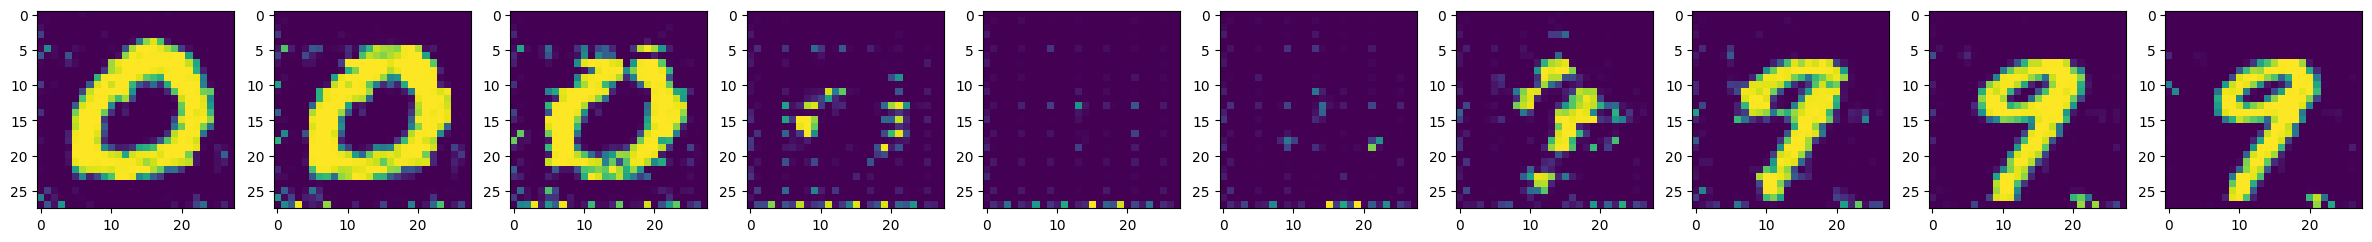

In [149]:
images = []
for z_k in z_interpolations:
    with torch.no_grad():
        img_k = G(z_k[:, :, None, None])
    images.append(img_k.detach().cpu().numpy().squeeze())

_, axs = plt.subplots(1, 10, figsize=(30, 3))
for (ax, img) in zip(axs, images):
    ax.imshow(img)
plt.show()

## Additional experiment with CLIP-image encoder

Training custom encoder on same data domain is fine, but ideally we would like to utilize some big pretrained thing with good embeddings for the suppoert of generation model. Let's try this with CLIP

In [4]:
import clip

In [6]:
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

100%|███████████████████████████████████████| 338M/338M [01:49<00:00, 3.23MiB/s]


In [11]:
holdout_mnist = MNIST(root="data", train=False, download=True)
image = holdout_mnist[0][0]
image_input = preprocess(image).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    image_feature = model.encode_image(image_input)
image_feature /= image_feature.norm()

In [14]:
image_feature.shape

torch.Size([1, 512])

In [84]:
z_dim=100
y_dim=512
G = Generator().to(DEVICE)
                  
for p in G.parameters():
    p.requires_grad = False

n_hidden=4
hidden_dim=256
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)
loss_fn = F.mse_loss

In [92]:
class BroadcastChannelTransform(object): # used to broadcast mnist image tensors
    def __init__(self, output_ch=3):
        self.output_ch = output_ch

    def __call__(self, images: torch.Tensor):
        if len(images.shape) == 4:
            bs, _, h, w = images.shape
            return images.broadcast_to((bs, self.output_ch, h, w))
        else:
            image = images
            _, h, w = image.shape
            return image.broadcast_to(self.output_ch, h, w)

In [86]:
n_px=model.visual.input_resolution
clip_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [87]:
to_pil = T.ToPILImage()
num_iters=500
bs=256

G.eval()
model.eval()
mapping.train()
p_bar = tqdm(range(num_iters))
for i in p_bar:
    optimizer.zero_grad()
    z = torch.randn((bs, z_dim), device=DEVICE)
    with torch.no_grad():
        images = G(z[:,:, None, None])
        images = clip_transform(images)
        y = model.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)
    loss = loss_fn(z_hat, z)
    loss.backward()
    optimizer.step()
    p_bar.set_description(f"loss: {loss.item():.5f}")

torch.save(mapping.state_dict(), f"models/mapping_clip_b_{n_hidden}_{hidden_dim}.pth")

loss: 1.00870: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:11<00:00,  2.61it/s]


In [88]:
eval_samples = [holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]

In [93]:
eval_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.ToTensor(),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

[Parameter containing:
tensor([[-1.2857e-13,  3.1570e-14,  2.4616e-15,  ...,  1.3129e-13,
         -6.8723e-15, -9.8156e-15],
        [-1.1214e-13,  3.0183e-14, -1.3166e-13,  ...,  5.5035e-14,
         -9.1410e-14,  5.3182e-14],
        [ 3.5298e-14,  1.3637e-13, -1.0708e-13,  ...,  7.6375e-14,
          1.4351e-13,  1.4893e-13],
        ...,
        [ 2.1795e-14, -1.9455e-13, -8.5898e-14,  ..., -6.6672e-15,
         -1.3199e-13, -8.8480e-14],
        [-1.2657e-13, -1.7660e-13,  1.6955e-13,  ..., -2.1322e-14,
          1.5476e-13, -8.7494e-14],
        [-1.2765e-14, -1.3531e-14,  2.6177e-14,  ...,  8.2367e-15,
         -1.2439e-13, -2.3872e-14]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-1.0259e-14, -5.1437e-14, -6.8756e-14, -6.0975e-14,  8.8435e-15,
        -4.6454e-14, -3.4121e-14,  1.2326e-13,  1.6715e-14, -6.0053e-14,
        -1.2467e-13,  4.4326e-14, -9.4306e-14,  1.1473e-13,  4.8337e-15,
         4.9569e-14, -5.3867e-15,  9.3405e-14,  9.6971e-14, -1.409

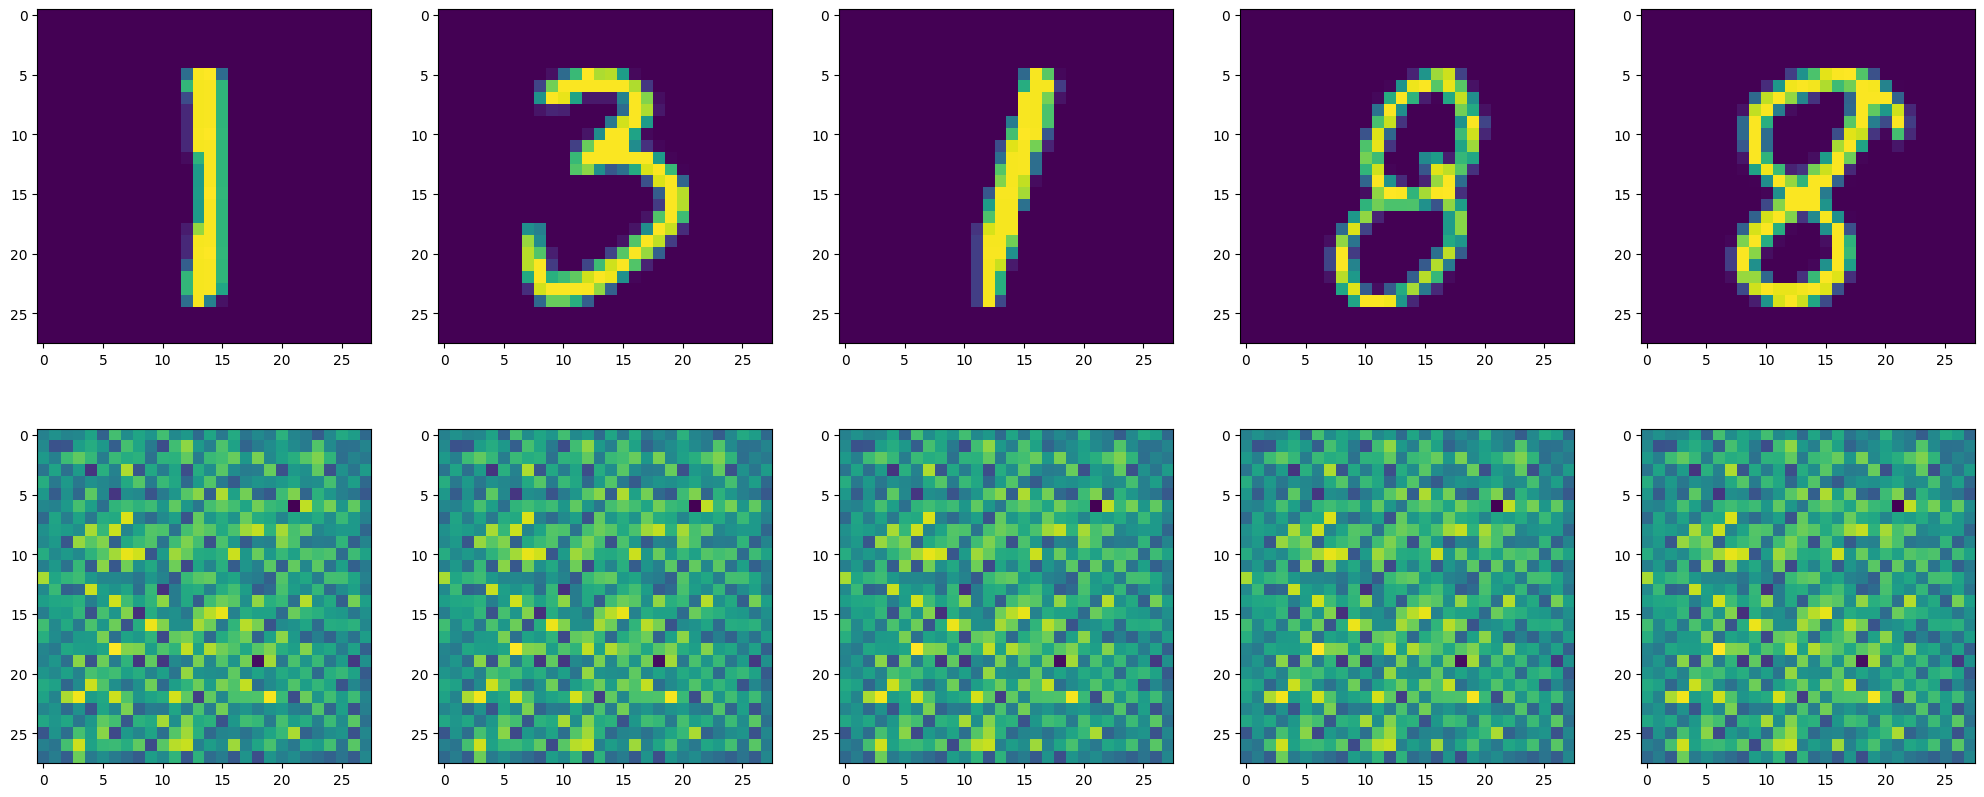

In [102]:
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    images = torch.stack([eval_transform(img) for img in eval_samples]).to(DEVICE)
    y = model.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)
    print(list(mapping.projection[0].parameters()))
    inv_samples = G(z_hat[:, :, None, None])

for i in range(5):
    img_orig = np.array(eval_samples[i]).reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()